# Import important shtuff

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [10]:
torch.manual_seed(42)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load Up the Data

In [12]:
train_data = pd.read_csv('fashion-mnist_train.csv')
test_data = pd.read_csv('fashion-mnist_test.csv')

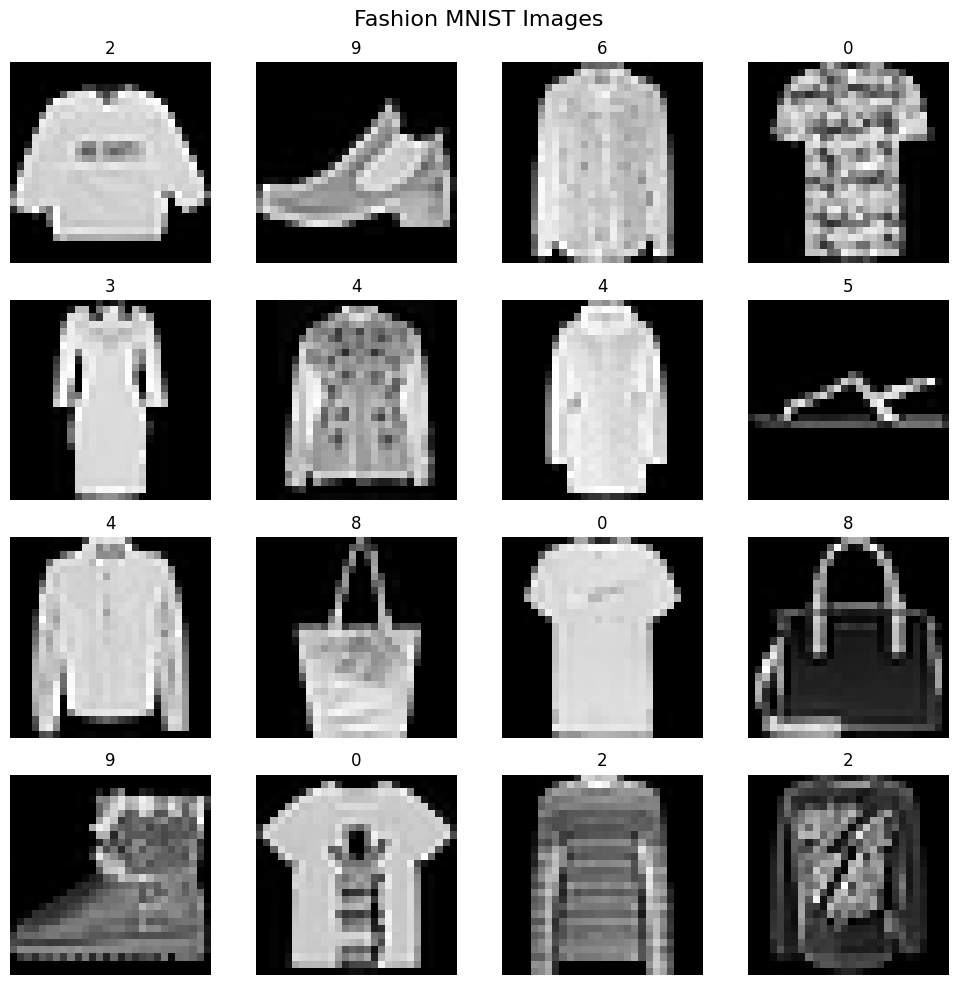

In [13]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('Fashion MNIST Images', fontsize=16)

for i, ax in enumerate(axs.flat):
    img = train_data.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img, cmap='grey')
    ax.axis('off')
    ax.set_title(train_data.iloc[i, 0])

plt.tight_layout()
plt.show()

In [14]:
# seperate data and labels
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values

X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

In [15]:
# normalize the values
X_train = X_train / 255.0
X_test = X_test / 255.0

In [16]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [17]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the Model

In [19]:
class MyNN(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)

# Training Pipeline

In [20]:
# important hyperparameters
learning_rate = 0.001
epochs = 50

In [21]:
# instantiate the model
model = MyNN(X_train.shape[1])
model = model.to(device)

# define loss
criterion = nn.CrossEntropyLoss()

# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [22]:
# training loop
loss_with_time = []

for epoch in range(epochs):
    total_epoch_loss = 0.

    for batch_features, batch_labels in train_loader:
        # cuda-fy tensors
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        # forward pass
        outputs = model(batch_features)

        # calculate loss
        loss = criterion(outputs, batch_labels)

        # backprop
        optimizer.zero_grad()
        loss.backward()

        # update grads
        optimizer.step()

        total_epoch_loss += loss.item()

    avg_epoch_loss = total_epoch_loss / len(train_loader)
    loss_with_time.append(avg_epoch_loss)
    # print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}')

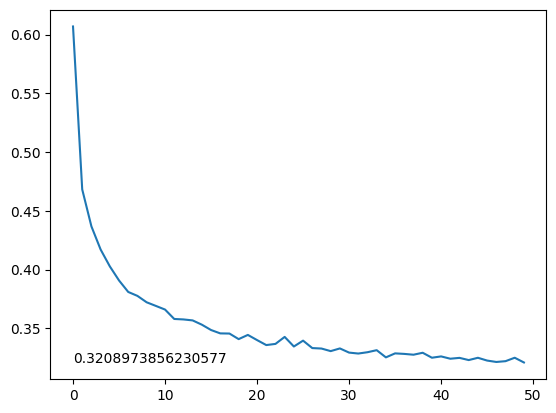

In [23]:
plt.annotate(loss_with_time[-1], (0, loss_with_time[-1]))
plt.plot(range(epochs), loss_with_time)
plt.show()

# Model Evaluation

In [24]:
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [25]:
# evalutaion (test data)
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)

        total += batch_labels.shape[0]
        correct += (predicted == batch_labels).sum().item()

print(f"accuracy: {correct / total}")

accuracy: 0.8967


In [26]:
# evalutaion (train data for overfit check)
total = 0
correct = 0

with torch.no_grad():
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)

        total += batch_labels.shape[0]
        correct += (predicted == batch_labels).sum().item()

print(f"accuracy: {(correct / total):.4f}")

accuracy: 0.9227
